This tutorial notebook shows how to use a neural network architecture for global epistasis regression other than the default choice provided by mavenn

In [14]:
# necessary imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import mavenn
from mavenn.src.utils import get_example_dataset
import tensorflow as tf

Load data using mavenn's helper method. 

In [2]:
X, y = get_example_dataset(name='MPSA')

In [3]:
# X is an array of 9-nt sequences
X[0:10]

array(['AAAGCAAAA', 'AAAGCAAAC', 'AAAGCAAAG', 'AAAGCAAAU', 'AAAGCAACA',
       'AAAGCAACC', 'AAAGCAACG', 'AAAGCAACU', 'AAAGCAAGA', 'AAAGCAAGC'],
      dtype=object)

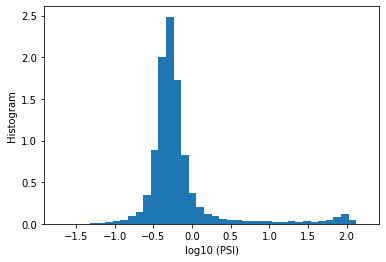

In [4]:
# y = log_10(PSI)
plt.hist(y,bins=40,density=True)
plt.xlabel('log10 (PSI)')
plt.ylabel('Histogram')
plt.show()

In [5]:
# Split data into training and test sets using sklearn
x_train, x_test, y_train, y_test = train_test_split(X, y)

## Define custom model

In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input

# Here we define a custom model based on the tf.keras Model api. 
# For this example we will define an additive model and 
# fit it to mpsa data
number_input_layer_nodes = len(x_train[0])*4
inputTensor = Input((number_input_layer_nodes,))
phi = Dense(1)(inputTensor)
custom_model = Model(inputTensor,phi)

## Fit GE model to data

In [7]:
# the important keyworkd here is 'custom_architecture'
GER = mavenn.Model(regression_type='GE',
                   X=x_train, 
                   y=y_train, 
                   model_type='additive',
                   learning_rate=0.0005,
                   monotonic=True,
                   alphabet_dict='rna',
                   custom_architecture=custom_model)

GER.fit(epochs=100, use_early_stopping=True, early_stopping_patience=20, verbose=1)

Train on 18717 samples, validate on 4680 samples
Epoch 1/100
18717/18717 [==============================] - 1s 39us/step - loss: 0.3680 - mean_absolute_error: 0.4476 - val_loss: 0.2638 - val_mean_absolute_error: 0.3656
Epoch 2/100
18717/18717 [==============================] - 1s 28us/step - loss: 0.2183 - mean_absolute_error: 0.3179 - val_loss: 0.2050 - val_mean_absolute_error: 0.3017
Epoch 3/100
18717/18717 [==============================] - 1s 29us/step - loss: 0.1940 - mean_absolute_error: 0.2927 - val_loss: 0.1979 - val_mean_absolute_error: 0.2922
Epoch 4/100
18717/18717 [==============================] - 1s 34us/step - loss: 0.1917 - mean_absolute_error: 0.2904 - val_loss: 0.1973 - val_mean_absolute_error: 0.2918
Epoch 5/100
18717/18717 [==============================] - 1s 35us/step - loss: 0.1916 - mean_absolute_error: 0.2905 - val_loss: 0.1973 - val_mean_absolute_error: 0.2917
Epoch 6/100
18717/18717 [==============================] - 1s 37us/step - loss: 0.1916 - mean_absolut

## Plot results

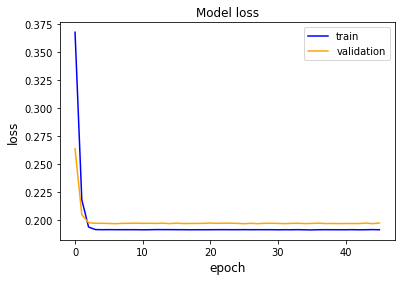

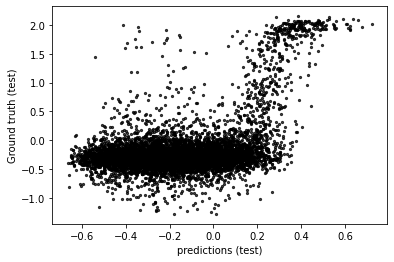

In [8]:
# since this is a linear model, we do not have global epistasis nonlinearity in this case
loss_history =  GER.model.return_loss()
predictions = GER.model.predict(x_test)

plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

plt.scatter(predictions,y_test,s=5, alpha=0.75, color='black')
plt.ylabel('Ground truth (test)')
plt.xlabel('predictions (test)')
plt.show()


A more complicated architecture is shown below

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.constraints import non_neg as nonneg

# For this example we will define an additive GE model
# with 2 hidden layers in the GE sub-network
number_input_layer_nodes = len(x_train[0])*4
inputTensor = Input((number_input_layer_nodes,))
phi = Dense(1)(inputTensor)
intermediateTensor = Dense(30, activation='sigmoid', kernel_constraint=nonneg())(phi)
intermediateTensor = Dense(10, activation='sigmoid', kernel_constraint=nonneg())(intermediateTensor)
outputTensor = Dense(1, kernel_constraint=nonneg())(intermediateTensor)

custom_model_GE = Model(inputTensor,outputTensor)

In [10]:
# the important keyworkd here is 'custom_architecture'
GER_denser = mavenn.Model(regression_type='GE',
                   X=x_train, 
                   y=y_train, 
                   model_type='additive',
                   learning_rate=0.0005,
                   monotonic=True,
                   alphabet_dict='rna',
                   custom_architecture=custom_model_GE)

GER_denser.fit(epochs=100, use_early_stopping=True, early_stopping_patience=20, verbose=1)

Train on 18717 samples, validate on 4680 samples
Epoch 1/100
18717/18717 [==============================] - 1s 62us/step - loss: 0.2723 - mean_absolute_error: 0.3621 - val_loss: 0.2534 - val_mean_absolute_error: 0.2996
Epoch 2/100
18717/18717 [==============================] - 1s 43us/step - loss: 0.2436 - mean_absolute_error: 0.2874 - val_loss: 0.2522 - val_mean_absolute_error: 0.2813
Epoch 3/100
18717/18717 [==============================] - 1s 43us/step - loss: 0.2433 - mean_absolute_error: 0.2799 - val_loss: 0.2523 - val_mean_absolute_error: 0.2777
Epoch 4/100
18717/18717 [==============================] - 1s 46us/step - loss: 0.2433 - mean_absolute_error: 0.2788 - val_loss: 0.2525 - val_mean_absolute_error: 0.2746
Epoch 5/100
18717/18717 [==============================] - 1s 49us/step - loss: 0.2432 - mean_absolute_error: 0.2785 - val_loss: 0.2521 - val_mean_absolute_error: 0.2834
Epoch 6/100
18717/18717 [==============================] - 1s 42us/step - loss: 0.2432 - mean_absolut

Epoch 49/100
18717/18717 [==============================] - 1s 41us/step - loss: 0.0897 - mean_absolute_error: 0.1820 - val_loss: 0.0901 - val_mean_absolute_error: 0.1823
Epoch 50/100
18717/18717 [==============================] - 1s 42us/step - loss: 0.0897 - mean_absolute_error: 0.1818 - val_loss: 0.0902 - val_mean_absolute_error: 0.1823
Epoch 51/100
18717/18717 [==============================] - 1s 43us/step - loss: 0.0896 - mean_absolute_error: 0.1821 - val_loss: 0.0903 - val_mean_absolute_error: 0.1819
Epoch 52/100
18717/18717 [==============================] - 1s 46us/step - loss: 0.0898 - mean_absolute_error: 0.1819 - val_loss: 0.0901 - val_mean_absolute_error: 0.1819
Epoch 53/100
18717/18717 [==============================] - 1s 40us/step - loss: 0.0897 - mean_absolute_error: 0.1820 - val_loss: 0.0900 - val_mean_absolute_error: 0.1825
Epoch 54/100
18717/18717 [==============================] - 1s 43us/step - loss: 0.0895 - mean_absolute_error: 0.1818 - val_loss: 0.0905 - val_me

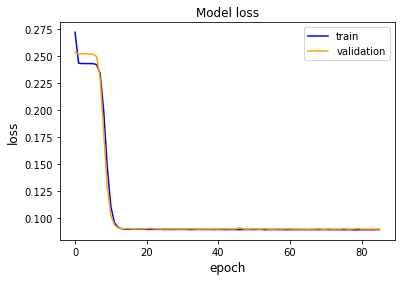

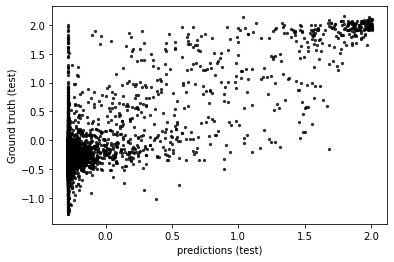

In [11]:
# since this is a linear model, we do not have global epistasis nonlinearity in this case
loss_history =  GER_denser.model.return_loss()
predictions = GER_denser.model.predict(x_test)

plt.plot(loss_history.history['loss'], color='blue')
plt.plot(loss_history.history['val_loss'], color='orange')
plt.title('Model loss', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['train', 'validation'])
plt.show()

plt.scatter(predictions,y_test,s=5, alpha=0.75, color='black')
plt.ylabel('Ground truth (test)')
plt.xlabel('predictions (test)')
plt.show()


In [12]:
denser_model = GER_denser.nn_model()

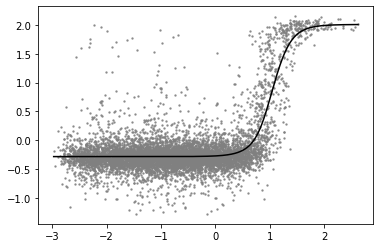

In [13]:
GE_nonlinearity = GER_denser.ge_nonlinearity(x_test)
plt.plot(GE_nonlinearity[1],GE_nonlinearity[0],color='black')
plt.scatter(GE_nonlinearity[2],y_test,color='gray',s=2,alpha=0.75)
plt.show()